In [3]:
import numpy as np
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from sklearn.datasets.samples_generator import make_circles
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
sns.set()

In [56]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [24]:
from numpy import genfromtxt
import pandas as pd
X = pd.read_csv('X.csv')

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = X
principalComponents = pca.fit_transform(x_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca = principalDf
data_df = df_pca
df_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3295 entries, 0 to 3294
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   principal component 1  3295 non-null   float64
 1   principal component 2  3295 non-null   float64
dtypes: float64(2)
memory usage: 51.6 KB


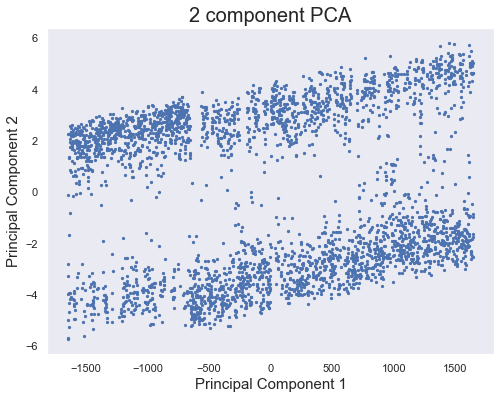

In [32]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(df_pca['principal component 1'],df_pca['principal component 2'], s = 5)
ax.grid()
#plt.savefig('2D-PCA_3_clusters.jpg',dpi=300)

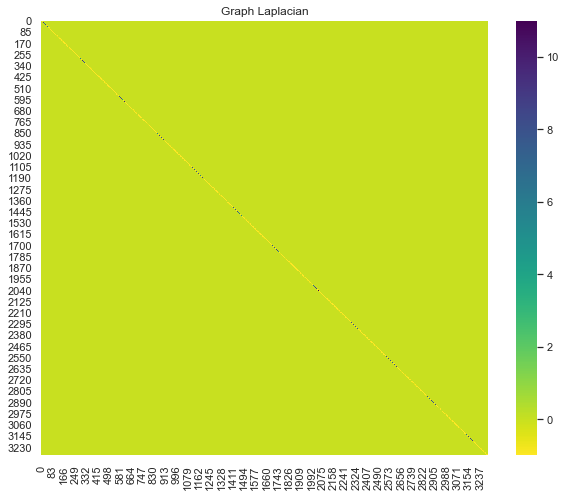

In [47]:
#https://www.kdnuggets.com/2020/05/getting-started-spectral-clustering.html

from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=df_pca, nn=8)

# Plot the graph Laplacian as heat map.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');

In [62]:
data_df = df_pca
#Step 2: Compute Spectrum of the Graph Laplacian
#Next, we compute the eigenvalues and eigenvectors of the graph Laplacian.

from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)

In [63]:
np.unique(np.imag(eigenvals))

array([0.000])

In [64]:
# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

In [65]:
#We now compute the L^2 Equation-norms of the eigenvectors.

eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=2), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))



Min Norm: 0.9999999999999997
Max Norm: 1.0000000000000002


In [66]:
#Hence, all of the eigenvectors have length ~ 1.
#We then sort the eigenvalues in ascending order.

eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

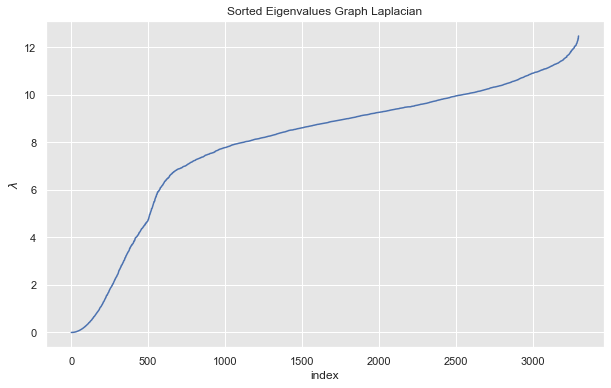

In [67]:
#Let us plot the sorted eigenvalues.

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

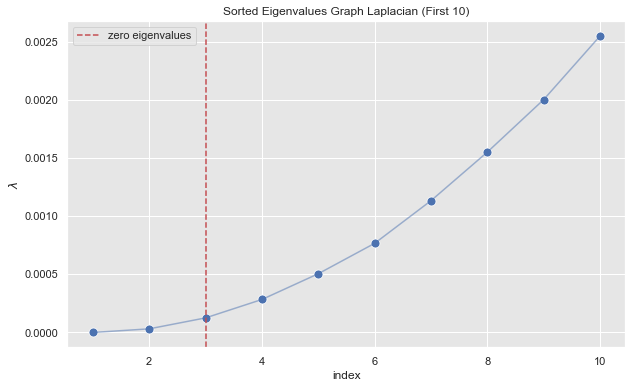

In [68]:
# Step 3: Find the Small Eigenvalues

# Let us zoom in into small eigenvalues.

index_lim = 10

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

In [69]:
# From the plot we see see that the first 33 eigenvalues (sorted) are essentially zero.

zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5)
eigenvals[zero_eigenvals_index]

array([[0.000]])

In [70]:
#For these small eigenvalues, we consider their corresponding eigenvectors.

proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
proj_df.head()

,v_0
0,-0.017421
1,-0.017421
2,-0.017421
3,-0.017421
4,-0.017421


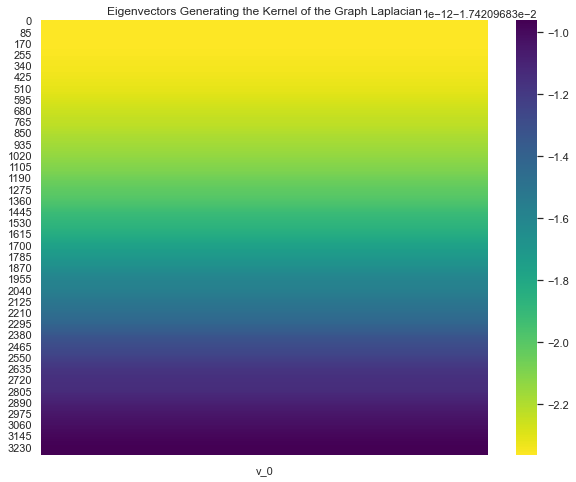

In [71]:
#Let us visualize this data frame as a heat map:

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(proj_df, ax=ax, cmap='viridis_r')
ax.set(title='Eigenvectors Generating the Kernel of the Graph Laplacian');

We can clearly see a block structure (representing the connected components). In general, finding zero eigenvalues, or the spectral gap happens, is to restrictive when the clusters are not isolated connected components. Hence, we simply choose the number of clusters we want to find.

In [72]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first 
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df